In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
try:
    from Detect_peaks import detect_peaks
except Exception as ep:
    print (ep)
    def detect_peaks(y,mph,mpd=10):
        from peakutils import indexes
        return indexes(y, thres=mph, min_dist=mpd) 
from glob import glob1
import os
from Binning_scipy import bin_edge2_bin_center,bin_data_given_bin_center
from theoretical_ion_spacings import theoretical_ion_spacing_um

C:\ProgramData\Miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Miniconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import matplotlib
textsize = 30
matplotlib.rcParams.update({'font.size': textsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 10,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': 32.0,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': textsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': textsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)


# Theoretical spacing

In [3]:
default_ion_position = theoretical_ion_spacing_um(numions=10,endcap_voltages=[263,275])
print (default_ion_position)

[-21.00406859 -15.36476737 -10.61178106  -6.24663985  -2.06397093
   2.06397093   6.24663985  10.61178106  15.36476737  21.00406859]


In [41]:
def plot_theoretical_spacing(ax,ion_position=default_ion_position,color='red',alpha=0.45):
    for j in range(len(ion_position)):
        ax.axvline(x=ion_position[j],ls='--',color=color,alpha=alpha,zorder=0)

# Analysis method : 
1. Off-resonant Spontaneous scattering: Fit -1*log10(1-dark state population)
2. Off-resonant Raman driving, Ramsey readout: Fit Arccosine(Sqrt(dark state population))
3. Off-resonant Raman driving, Ramsey readout: Fit dark state population

In [251]:


def spontaneous(p_d):
    return -1*np.log10(p_d)

def raman_dark(p_d):
    return p_d

def raman_cosine(p_d):
    if np.nanmax(p_d) >=1:
        p_d /= np.nanmax(p_d)
    return np.arccos(2*p_d-1)
#     return np.arccos(np.sqrt(p_d))

def default():
    print ('Analysis mode not available. Please choose from 1 to 3')
switcher = {1: lambda x: spontaneous(x), 2: lambda x:raman_cosine(x), 3: lambda x: raman_dark(x)}

def analysis_output(p_d,mode=1):
    return switcher.get(mode, default)(p_d)
    


# PMT data

In [252]:
header = '135859_'
# header = '133638_'
header = '170059_'
# header = '163753_'
foldername = '2022-02-15' # '2022-02-03'

directory = r'Z:\qfc\measurements\trics_data\\'+foldername +'\\' + header[:-1]
saved_directory = r'Z:\qfc\users\Zak'+'\\'+foldername+'_data_analysis'
flst = glob1(directory,'*PMT1_2*.txt')

analysis_mode = 2
num_ions = 6

print (flst)

['PMT1_2.txt']


In [253]:
# filename = os.path.join(directory,flst[0])
filename1 = os.path.join(directory,flst[0])
# data  = np.loadtxt(filename,skiprows=1)
data1 =  np.loadtxt(filename1,skiprows=1)
aod_freq = data1[:,2]/2
# counts = data[:,5]
counts1 = data1[:,5]
normalize = lambda x: -1*(x - x[3:10].mean())

def remove_annomally(x,threshold=5000):
    '''
    Remove noise from the data,
    default threshold is 5000
    Return boolean array showing all valid data as True
    '''
    diff = np.concatenate([np.zeros(1),np.diff(x)])
    valid = np.ones(len(x),dtype='bool')
    cnt = 0
    for j in range(len(diff)):
        if abs(diff[j])>threshold:
            valid[j] = False
            cnt += 1
    print (f'Left with {len(x)-cnt:.0f}/{len(x):.0f} or {100-100*cnt/len(x):.2f}%')
    return valid

# First determine the threshold

In [254]:
def poissonian(x,mean):
    from scipy.special import factorial
    mean = abs(mean)
    return (mean**x*np.exp(-mean))/(factorial(x))


def double_poissonian_fit(x,y,peakpos=[1,100],plot=False):
    from lmfit.models import GaussianModel
    poi1 = GaussianModel(prefix='p1_')
    poi2 = GaussianModel(prefix='p2_')
    mod = poi1 + poi2
    index1 = np.searchsorted(x,peakpos[0])
    index2 = np.searchsorted(x,peakpos[1])
    sep = int(10)
    params = poi1.guess(y[index1-sep:index1+sep],x=x[index1-sep:index1+sep]) + poi2.guess(y[index2-sep:index2+sep],x=x[index2-sep:index2+sep])
    params['p1_amplitude'].set(min=0)
    params['p2_amplitude'].set(min=0)
    result = mod.fit(y,params,x=x)

    if plot:
        print (result.fit_report())
        plt.plot(x,mod.eval(result.params,x=x),color='darkorange')
    
    return result, mod , poi1,poi2

In [255]:

all_counts = data1[:,6:].flatten()
melting_counts = 1200
clean_counts = all_counts[all_counts<melting_counts]

x,y = bin_data_given_bin_center(clean_counts,np.ones(len(clean_counts)),
                                opt='sum',nbin=200)

# plt.axvline(x=870,ls='--',color='black')

plt.bar(x,y,width=10,color='navy')
peakcounts = [num_ions*70,num_ions*90]#[800,900] #[450,550]

res,modtotal,mod1,mod2 = double_poissonian_fit(x,y,peakcounts,False)
def extract_threshold(res,mod1,mod2,x):
    distri1 = mod1.eval(res.params,x=x)
    distri2 = mod2.eval(res.params,x=x)
    weighting = (distri2+0.1)/(distri1+0.1)
    threshold = x[weighting.argmin() + np.argmin(abs(weighting[weighting.argmin():weighting.argmax()]-weighting[0]))]
    return (threshold)
threshold = extract_threshold(res,mod1,mod2,x)
plt.axvline(x=threshold,ls='--',color='black')
plt.xlabel('Counts')
plt.ylabel('Occurence')
plt.xlim(left=0)
plt.savefig(os.path.join(saved_directory,header+flst[0][:-4]+'_histogram.png'),dpi=100,bbox_inches='tight',facecolor='white')

# Compute population

In [256]:
def get_populations(y,threshold,toomuch=100000):
    p1 = 0
    total = 0
    for j in range(len(y)):
        total += y[j]
        if y[j]> threshold and y[j]<toomuch:
            p1 += y[j]
    p1 = p1/total
    return 1- p1, p1

In [257]:
pop = np.zeros((len(data1),2))
for j in range(len(data1)):
    p0,p1 = get_populations(data1[j][6:],threshold=threshold-0,toomuch=melting_counts)
    pop[j][0] = p0
    pop[j][1] = p1
    
spot_intensity = analysis_output(pop[:,1],mode=analysis_mode)# -1*np.log10(pop[:,1])

    

# Slightly clean up the data


Left with 195/200 or 97.50%


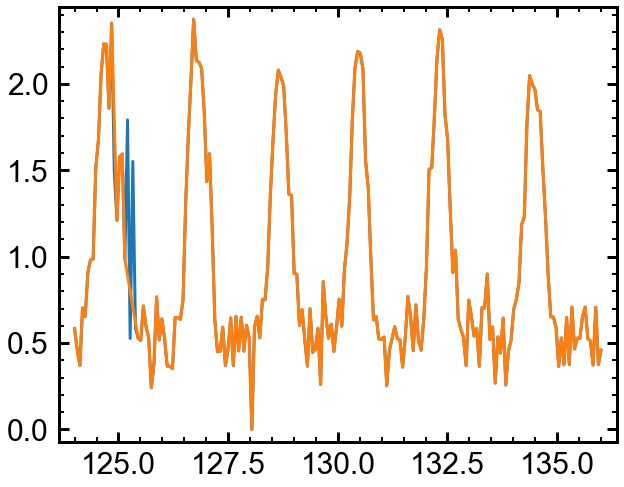

In [258]:
plt.plot(aod_freq,spot_intensity)
valid =remove_annomally(spot_intensity,threshold=.8) 
plt.plot(aod_freq[valid][:],spot_intensity[valid][:])

# Fit and display data

In [259]:
normalise = lambda x: x/np.nanmax(x)

indexstart = 0 # 8# 0
newx = aod_freq[valid][indexstart:]
newy = spot_intensity[valid][indexstart:]

binx,biny = bin_data_given_bin_center(newx,newy,opt='mean',bin_center=np.linspace(min(newx),max(newx),int(len(newx)/2)))
newx = binx
newy = normalise(biny)

peakpos = detect_peaks(newy,mpd=8,mph=np.nanmax(newy)/2.7)
print (f'Found {len(peakpos):.0f} peaks')


from lmfit.models import GaussianModel,ConstantModel,LorentzianModel

mod = ConstantModel()
params = mod.guess(newy,x=newx)
params['c'].set(vary=not False,value=1e-3)

for j in range(len(peakpos)):
    start = peakpos[j]-7
    if start<0:
        start= 0 
    end =  peakpos[j]+7
    if end>len(newy):
        end = len(newy)-1
#     print (start,end)
    newyy = newy[start:end]
    newxx = newx[start:end]
    mod += GaussianModel(prefix='g%s'%j)
#     plt.plot(newxx,newyy)
    params += GaussianModel(prefix='g%s'%j).guess(newyy,x=newxx)

result = mod.fit(newy,params,x=newx,weights=1/np.sqrt(newy),nan_policy='omit')

centers = [np.array(result.params)[1:][1+5*j] for j in range(len(peakpos))]
correction_center = np.median(centers)

f = plt.figure()
ax  =f.add_subplot(111)
ax1 = ax.twiny()
dummyx = np.linspace(min(newx),max(newx),1000)
plot_theoretical_spacing(ax,ion_position=default_ion_position,color='lightgrey',alpha=0)

ax1.plot(dummyx,mod.eval(result.params,x=dummyx),color='navy',lw=4,zorder=1,alpha=0.25*0)
ax1.plot(newx,newy,'-',color='navy',alpha=0.25*0,zorder=0)
# ax1.plot(binx,biny,'-',color='navy',alpha=0.25,zorder=0)

def convert2um(x,x0=None,conversion=3.03):
    if x0 is not None:
        return (x-x0)*conversion
    else:
        return (x-np.median(x))*conversion

ax.plot(convert2um(dummyx,correction_center,3.03),mod.eval(result.params,x=dummyx),color='navy',lw=4,zorder=2)
ax.plot(convert2um(newx,correction_center,3.03),newy,'-',color='navy',zorder=1,alpha=0.25)

ax1.set_xlabel('AOD Frequency (MHz)')
ax.set_xlabel(r'Spacing ($\mathregular{\mu m}$)')
if analysis_mode ==1:
    ax.set_ylabel(r'-Log[$\mathregular{p_B}$]')
elif analysis_mode ==2:
    ax.set_ylabel(r'Arccos($\sqrt{\mathregular{p_D}}$)')
else:
    ax.set_ylabel(r'$\mathregular{p_B}$')

prev= np.array(result.params)[2+5*0]
_fwhm = []
_fwhm.append(np.array(result.params)[4]*3.03)
_2sigma = []
_2sigma.append(2*np.array(result.params)[3]*3.03)
sep = []
for j in range(1,len(peakpos),1):
#     ax1.axvline(x=np.array(result.params)[2+5*j])
    diff = np.array(result.params)[2+5*j] - prev
    prev = np.array(result.params)[2+5*j] 
    fwhm = np.array(result.params)[4+5*j]
#     print (f'sep is {diff*3.03:.2f} um')
#     print (f'fwhm is {fwhm*3.03:.2f} um')
    sep.append(diff*3.03)
    _fwhm.append(fwhm*3.03)
    _2sigma.append(2*np.array(result.params)[3+5*j]*3.03)


ax.text(-20,1.3,'Sep.=%.2f$\,$(%.0f)$\,\mathregular{\mu m}$'%(np.mean(sep),100*np.std(sep)))
ax.text(-20,1.2,'FWHM.=%.2f$\,$(%.0f)$\,\mathregular{\mu m}$'%(np.mean(_fwhm),100*np.std(_fwhm)))
ax.text(-20,1.1,r'$\mathregular{2\sigma}$=%.2f$\,$(%.0f)$\,\mathregular{\mu m}$'%(np.mean(_2sigma),100*np.std(_2sigma)))


ax.set_ylim(bottom=0,top=1.4)
f.savefig(os.path.join(saved_directory,header+flst[0][:-4]+'_mode'+str(analysis_mode)+'_peaks.png'),dpi=100,bbox_inches='tight',facecolor='white')    

global const
const = result.params['c'].value

Found 6 peaks


# Plot from camera pictures

In [260]:
def load_data(path,folder,specific):
    full_path = path + folder + '\\camera_all.txt'
    data = np.loadtxt(full_path)
    data_num = data[:,0]
    prev = data_num[-1]
    valid = np.ones(len(data_num),dtype='bool')
    for j in range(len(data_num)-2,0,-1):
        if data_num[j] == prev:
            valid[j] = False
        prev = data_num[j]
    x = np.genfromtxt(path+folder +'\\%s.txt'%specific,usecols=range(2,3),skip_header=1)

    return data[valid][:,1:],x

In [275]:
def Gaussian_fit_single(x,y,peakpos=None,plot=False):
    from lmfit.models import GaussianModel,ConstantModel

    mod = GaussianModel()
    con = ConstantModel()
    params = mod.guess(y,x=x) +con.guess(y,x=x)
    mod += con
#     params['c'].set(value=const,vary=False)
    if peakpos is None:
        pass
    else:
        params['center'].set(value=peakpos)
    result = mod.fit(y,params,x=x,weights=1/np.sqrt(y),nan_policy='omit')
    if plot:
        plt.plot(x,y)
        plt.plot(x,result.best_fit)
    return result, mod

In [276]:
_data,AOD = load_data(path=directory,folder="",specific='Camera1_1')
AOD = AOD/2

data =   analysis_output(1-_data,mode=analysis_mode)
# data = -np.log(1-data + 1e-4)
# data = data/np.max(data[:-3])

In [281]:
f = plt.figure(figsize=(18,10))
# f = plt.figure()
ax = f.add_subplot(111)
ax1 = ax.twiny()
plot_theoretical_spacing(ax,ion_position=default_ion_position,
                        color='lightgrey',alpha=0)
colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

_fwhm = np.zeros((data.shape[1],2))
_sigma = np.zeros((data.shape[1],2))
center = np.zeros((data.shape[1],2))
max_value = 2.5 # .399 # .257
for j in range(data.shape[1]):

    valid =remove_annomally(data[:,j],threshold=.5) 
#     binx,biny = bin_data_given_bin_center(AOD[valid],data[:,j][valid],bin_center=np.linspace(min(AOD),max(AOD),100))
    x = AOD[valid] # binx
    y = data[:,j][valid]/max_value # biny

#     plt.plot(AOD[valid],data[:,j][valid],'o')
    peakpos = detect_peaks(y,mpd=10,mph=max(y)/2)[0]
    peak = AOD[valid][peakpos]
    res,mod = Gaussian_fit_single(x,y,peakpos=peak,plot=False)
    peakamplitude = res.params['height'].value
    
    dummyx = np.linspace(min(AOD),max(AOD),1000)
    ax1.plot(x,y,'-',alpha=0)
    ax1.plot(dummyx,mod.eval(res.params,x=dummyx),'-',color=colors[j],alpha=0)
    
    ax.plot(convert2um(x,x0=130.05353881693603),y,'-',alpha=0.5,color=colors[j])
    ax.plot(convert2um(dummyx,x0=130.05353881693603),mod.eval(res.params,x=dummyx),'-',lw=4,color=colors[j])
    _fwhm[j]= [res.params['fwhm'].value,res.params['fwhm'].stderr]
    _sigma[j]= [res.params['sigma'].value,res.params['sigma'].stderr]
    center[j]= [res.params['center'].value,res.params['center'].stderr]
    
ax1.set_xlabel('AOD Frequency (MHz)')
ax.set_xlabel(r'Spacing ($\mathregular{\mu m}$)')
if analysis_mode ==1:
    ax.set_ylabel(r'-Log[$\mathregular{1-p_D}$]')
elif analysis_mode ==2:
    ax.set_ylabel(r'Arccos($\sqrt{\mathregular{p_D}}$)')
else:
    ax.set_ylabel(r'$\mathregular{p_D}$')
    
# ax.set_ylabel(r'-Log[$1-\mathregular{p_D}$] (arb. units)')
ax.set_ylim(bottom=0)
ax1.set_ylim(bottom=0)

sep = abs(np.diff(center[:,0]))*3.03
print (f'Center ion at {np.median(center[:,0]):.5f}')

ymin, ymax = ax.get_ylim()
print (f'Ymax is {ymax:.3f}')
ymax -= 0.1
spacing = 0.1

# ax.text(-24,ymax,'Sep.=%.1f$\,$(%.0f)$\,\mathregular{\mu m}$'%(np.mean(sep),10*np.std(sep)))
ax.text(-20,ymax-spacing,'FWHM=%.1f$\,$(%.0f)$\,\mathregular{\mu m}$'%(3.03*np.mean(_fwhm[:,0]),3.03*10*np.std(_fwhm[:,0])))
ax.text(-20,ymax-2*spacing,r'$\mathregular{2\sigma}$=%.1f$\,$(%.0f)$\,\mathregular{\mu m}$'%(3.03*2*np.mean(_sigma[:,0]),3.03*2*10*np.std(_sigma[:,0])))


try:
    f.savefig(os.path.join(saved_directory,header+flst[0][:-4]+'_mode'+str(analysis_mode)+'_ccdpeaks_ref.png'),dpi=100,bbox_inches='tight',facecolor='white')
#     f.savefig(os.path.join(saved_directory,header+flst[0][:-4]+'_ccdpeaks_ref.eps'),dpi=600,bbox_inches='tight')
except:
    f.savefig(header+'_'+str(analysis_mode)+'_ccdpeaks_ref.png',dpi=100,bbox_inches='tight',facecolor='white')

Left with 198/200 or 99.00%
Left with 192/200 or 96.00%
Left with 194/200 or 97.00%
Left with 197/200 or 98.50%
Left with 197/200 or 98.50%
Left with 196/200 or 98.00%
Center ion at 129.59383
Ymax is 1.058


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


# Values needed for the blogspot

In [278]:
import pandas as pd
display = {"FWHM (um)":_fwhm[:,0]*3.03,
        "dFWHM (um)":_fwhm[:,1]*3.03,
        "2sigma (um)":3.03*2*(_sigma[:,0]),
         "d2sigma (um)":3.03*2*(_sigma[:,1]),
        "Center (um)":convert2um(center[:,0],x0= 130.05307)*3.03,
        "dCenter (um)":convert2um(center[:,1],x0= 0)*3.03}
pd.DataFrame(display)

FWHM (um)  dFWHM (um)  2sigma (um)  d2sigma (um)  Center (um)  dCenter (um)
0   1.411906    0.034964     1.199163      0.029695    40.580042      0.050862
1   1.294975    0.036826     1.099851      0.031277    21.090058      0.059175
2   1.260549    0.046796     1.070612      0.039745     4.012985      0.077420
3   1.467524    0.073495     1.246400      0.062421   -12.445394      0.101749
4   1.429299    0.050958     1.213935      0.043279   -29.741257      0.078848
5   1.635023    0.060053     1.388661      0.051004   -48.921776      0.086866